In [1]:
import numpy as np
import torch
import random
import os

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(seed=420)

                       open   close    high     low     volume
2013-04-01 00:07:00   93.25   93.30   93.30   93.25  93.300000
2013-04-01 00:08:00  100.00  100.00  100.00  100.00  93.300000
2013-04-01 00:09:00   93.30   93.30   93.30   93.30  33.676862
2013-04-01 00:10:00   93.30   93.30   93.30   93.30   0.000000
2013-04-01 00:11:00   93.35   93.47   93.47   93.35  20.000000
                        open    close     high      low    volume
2023-10-08 09:24:00  27927.0  27927.0  27927.0  27927.0  0.000000
2023-10-08 09:25:00  27927.0  27927.0  27927.0  27927.0  0.000000
2023-10-08 09:26:00  27927.0  27927.0  27927.0  27927.0  0.000000
2023-10-08 09:27:00  27927.0  27927.0  27927.0  27927.0  0.000000
2023-10-08 09:28:00  27912.0  27912.0  27912.0  27912.0  0.000442


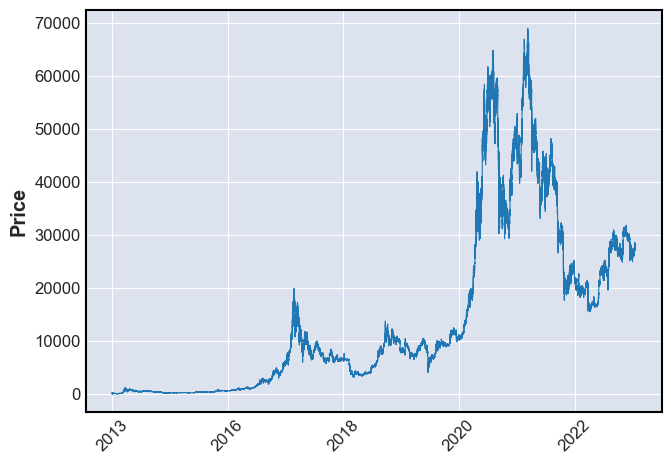

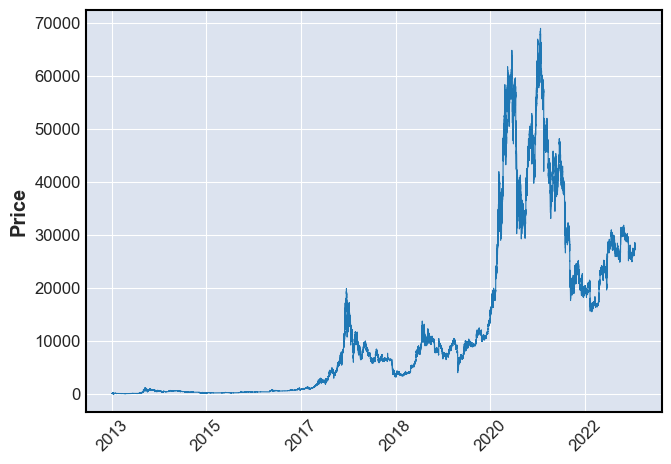

                       open   close    high     low    volume
2013-04-01 00:07:00   93.25   93.30   93.30   93.25  2.502149
2013-04-01 00:08:00  100.00  100.00  100.00  100.00  2.502149
2013-04-01 00:09:00   93.30   93.30   93.30   93.30  1.758977
2013-04-01 00:10:00   93.30   93.30   93.30   93.30 -0.875289
2013-04-01 00:11:00   93.35   93.47   93.47   93.35  1.386391 open      0.010000
close     1.060000
high      1.060000
low       0.010000
volume   -0.875289
dtype: float64 open      68925.000000
close     68925.000000
high      68958.000000
low       68734.000000
volume        5.725743
dtype: float64
(22132168,)
a 11.14126740407234 0.009950330853168092 8.135346188400915 1.9180121525920217


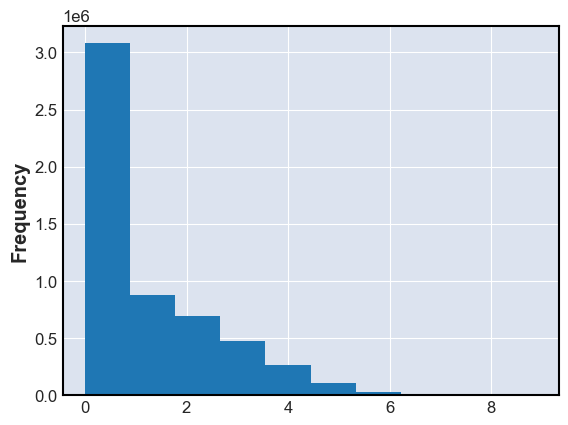

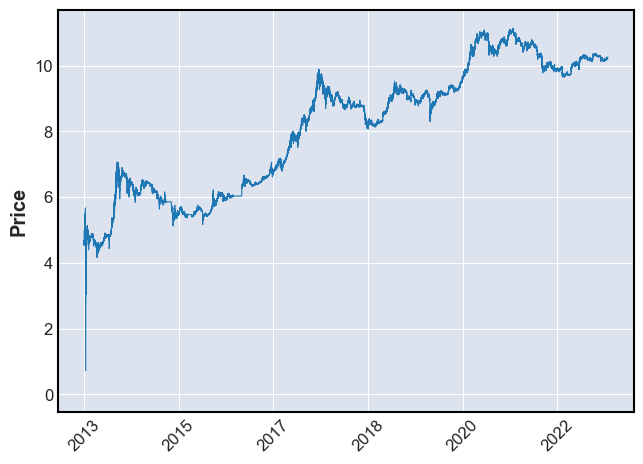

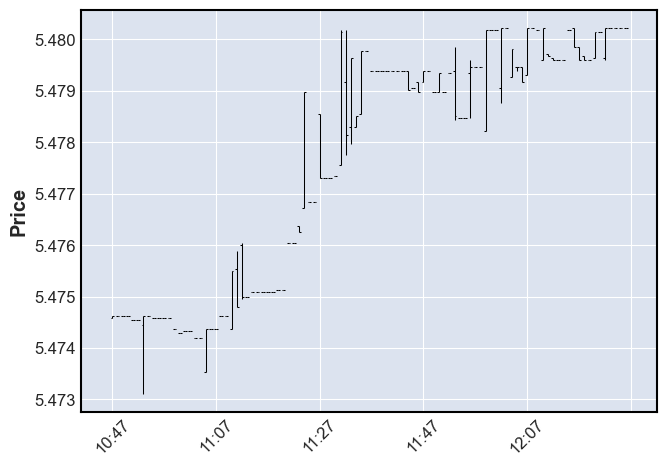

b 11.140788744310507 11.140788744310507 11.14126740407234 11.138013809905521
c 8.135346188400915 1.9180121525920217
d 8.13534605186366 8.135346456755373 8.135742682750113 8.134949562234455
e 1.9180136857301535 1.9180106789128473 1.9180444799344265 1.917980203230276
open 8.13534605186366 1.9180136857301535
high 8.135742682750113 1.9180444799344265
low 8.134949562234455 1.917980203230276
close 8.135346456755373 1.9180106789128473


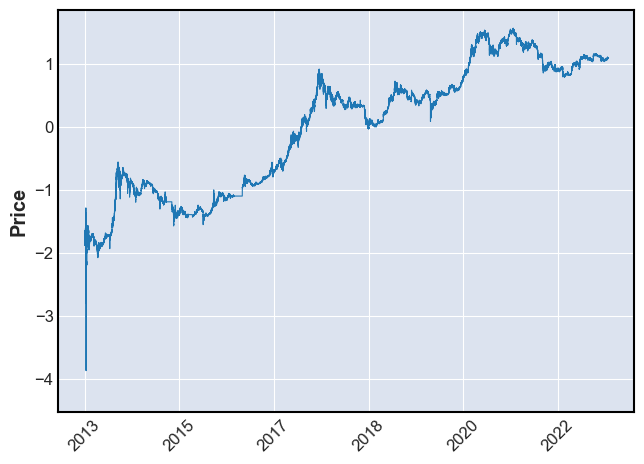

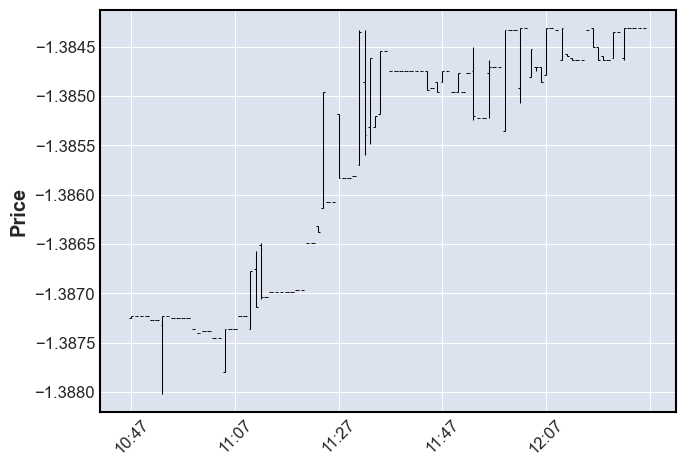

f 1.5669569933892264 1.5669569933892264 1.5672065537276139 1.5655102171520499
g -4.236363073386683 -3.8647514279729176 -3.8647514279729176 -4.236363073386683


In [2]:
%run load_data.ipynb

# Plot the predictions

In [3]:
def getPredictions(model, seq_length):
    # Ensure the model is in evaluation mode
    model.eval()

    sequences, targets = create_sequences(data, seq_length)

    # Prepare data for prediction
    entire_loader = DataLoader(TimeSeriesDataset(sequences, targets), batch_size, shuffle=False)

    # Generate predictions
    predictions = []

    with torch.no_grad():
        for x, _ in entire_loader:
            x = x.to(device)
            pred = model(x)
            predictions.append(pred.cpu().numpy())

    predictions = np.concatenate(predictions)
    
    return predictions

In [4]:
import matplotlib.pyplot as plt

def getPredPlot(model, seq_length):
    predictions = getPredictions(model, seq_length)
    # Convert predictions to a DataFrame
    pred_df = pd.DataFrame(predictions, columns=['open', 'close', 'high', 'low', 'volume'])

    # Plot the actual vs predicted close prices using matplotlib
    plt.figure(figsize=(14, 7))
    plt.plot(pred_df['close'], label='Predicted Close', color='red', linestyle='--')
    plt.title('Predicted Close Prices')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


In [5]:
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import torch
import random
import os
import time

# Convert DataFrame to numpy array
data = df_norm.values


# Create sequences and targets
def create_sequences(data, seq_length, start=0):
    sequences = []
    targets = []
    for j in range(start, len(data) - seq_length, seq_length):
        seq = data[j: j + seq_length]
        target = data[j + seq_length]
        sequences.append(seq)
        targets.append(target)
        
    return np.array(sequences), np.array(targets)


# Custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]


def get_dataloaders(seq_length=64, batch_size=64, epoch=0):
    # Create sequences and targets
    sequence, target = create_sequences(data, seq_length, epoch%seq_length)

    # Sequential split
    train_size = int(len(sequence) * 0.8)
    X_train, X_test = (
        sequence[:train_size],
        sequence[train_size:],
    )
    y_train, y_test = (
        target[:train_size],
        target[train_size:],
    )

    # Create Datasets
    train_dataset = TimeSeriesDataset(X_train, y_train)
    test_dataset = TimeSeriesDataset(X_test, y_test)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
    return train_loader, test_loader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Create RNN Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, conv1=16, conv2=8):
        super(LSTMModel, self).__init__()

        self.input_dim = input_dim

        # Number of hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        self.conv1_channels = conv1
        self.conv2_channels = conv2

        if self.conv2_channels > 0 and self.conv1_channels == 0:
            self.conv1_channels = self.conv2_channels
            self.conv2_channels = 0

        self.sigma = nn.Sigmoid()

        self.conv1 = nn.Conv2d(1, self.conv1_channels, (3, 3), padding=1)

        self.selu1 = nn.SELU()

        self.conv2 = nn.Conv2d(
            self.conv1_channels, self.conv2_channels, (3, 3), padding=1
        )

        self.selu2 = nn.SELU()

        self.conv3 = None
        if self.conv2_channels == 0:
            self.conv3 = nn.Conv2d(self.conv1_channels, 1, (3, 3), padding=1)
        else:
            self.conv3 = nn.Conv2d(self.conv2_channels, 1, (3, 3), padding=1)

        self.selu3 = nn.SELU()

        # RNN
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        if x.size(0) == 1:
            h0 = torch.zeros(self.layer_dim, self.hidden_dim).to(device)
            c0 = torch.zeros(self.layer_dim, self.hidden_dim).to(device)

        inp = self.sigma(x)
        out = None
        if self.conv1_channels == 0 and self.conv2_channels == 0:
            out, _ = self.lstm(self.selu1(inp), (h0, c0))
        else:
            inp = inp.unsqueeze(1)
            conv1 = self.selu1(self.conv1(inp))
            conv2 = None
            conv3 = None
            if self.conv2_channels > 0:
                conv2 = self.selu2(self.conv2(conv1))
                conv3 = self.selu3(self.conv3(conv2))
            else:
                conv3 = self.selu3(self.conv3(conv1))

            conv3 = conv3.squeeze()
            out, _ = self.lstm(conv3, (h0, c0))
        if x.size(0) == 1:
            out = self.fc(out[-1, :])
        else:
            out = self.fc(out[:, -1, :])
        return out


def train_model(model, optimizer, criterion, train_loader):
    start = time.time()
    model.train()
    for i, (x, y) in enumerate(train_loader):
        if time.time() - start > 600:
            break

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)
        loss = criterion(y_pred, y)
        
        wandb.log({"loss": loss})

        loss.backward()
        optimizer.step()
            
    return model


def eval_model(model, criterion, seq_length, test_loader):
    # Evaluate on test data
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation
        for x_test, y_test in test_loader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)

            y_test_pred = model(x_test)
            test_loss += criterion(y_test_pred, y_test).item()

    test_loss /= len(test_loader)  # Average test loss
    return test_loss


criterions = [
    nn.L1Loss(),
    nn.MSELoss(),
    nn.HuberLoss(),
    nn.SmoothL1Loss(),
    nn.SoftMarginLoss(),
]

Test loss 0.12037161612914181


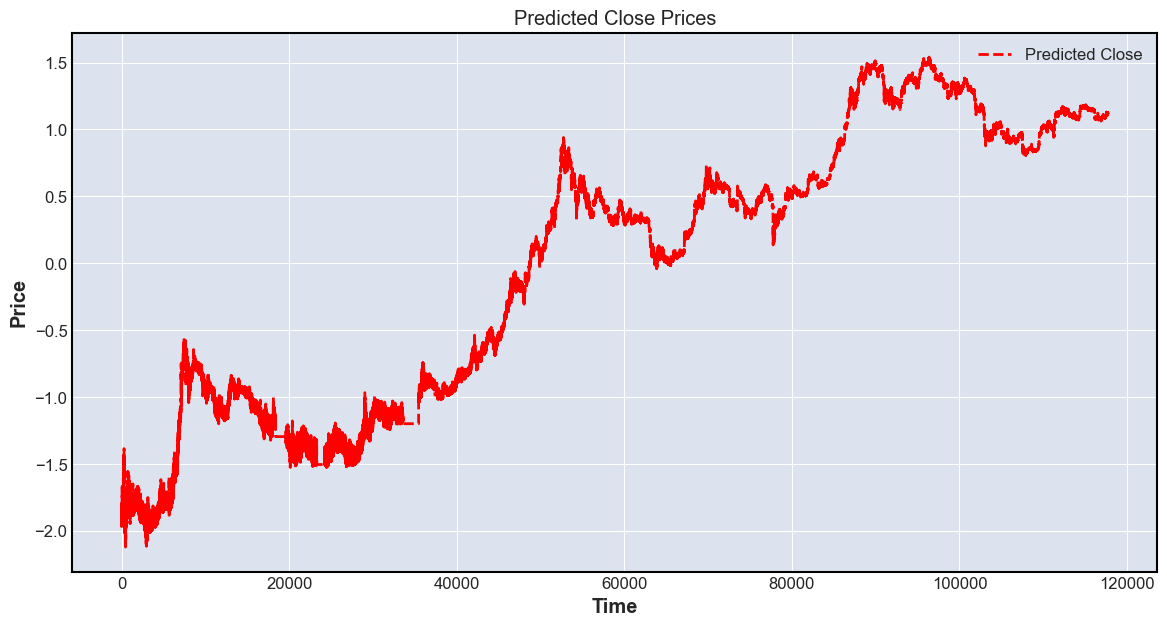

Test loss 0.10665461997946198


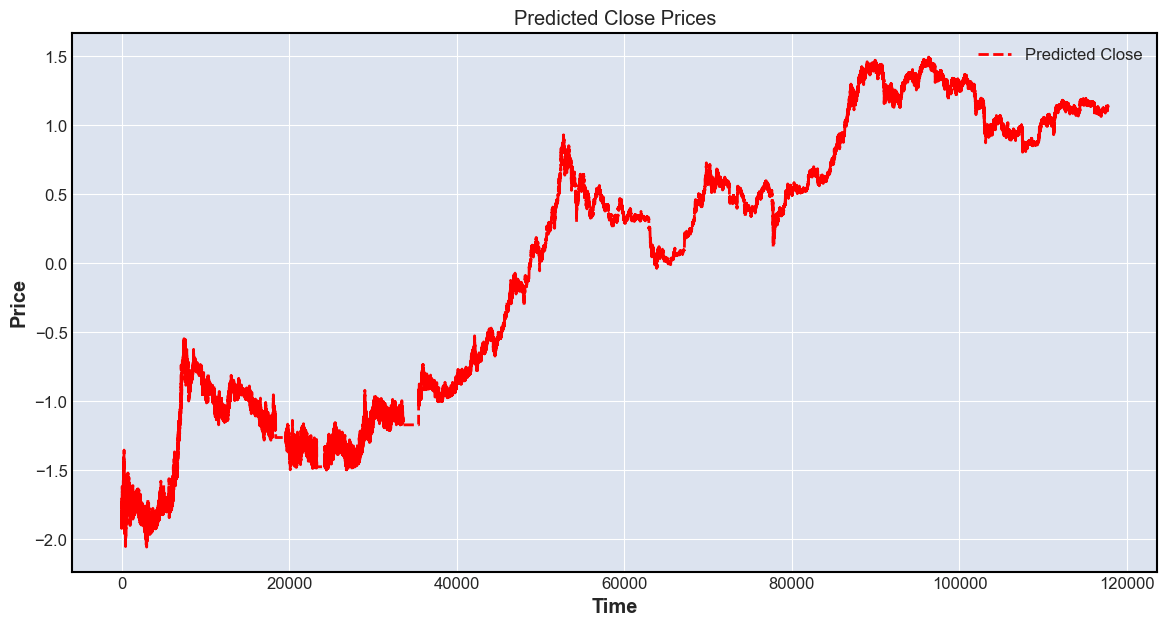

Test loss 0.13991849161596026


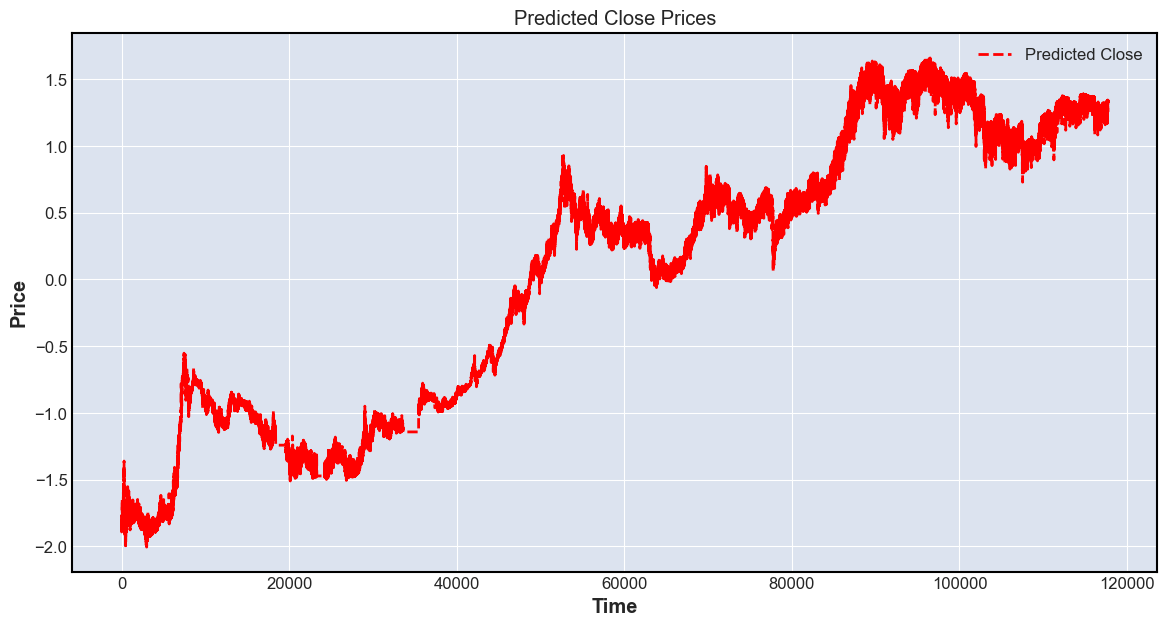

Test loss 0.05863711746484749


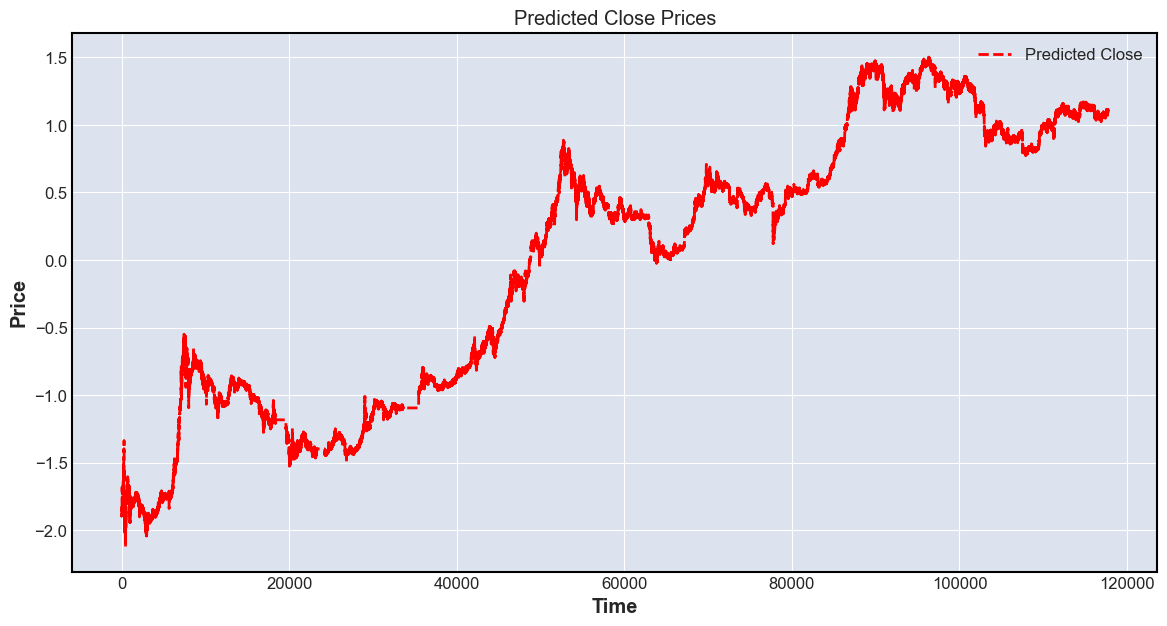

Test loss 0.055011394793154436


KeyboardInterrupt: 

In [28]:
# hidden_dim = 2
# layer_dim = 163
# conv1 = 51
# conv2 = 3
# criterion_id = 3
# seq_length = 226
# batch_size = 60
# lr = 0.00018619403646471432
# hidden_dim = 27
# layer_dim = 141
# conv1 = 27
# conv2 = 0
# criterion_id = 3
# seq_length = 215
# batch_size = 58
hidden_dim = 1718
layer_dim = 7
conv1 = 9
conv2 = 7
criterion_id = 3
seq_length = 47
batch_size = 56
lr = 1.7202934434750757e-05
model = LSTMModel(
    input_dim=5,
    hidden_dim=hidden_dim,
    layer_dim=layer_dim,
    output_dim=5,
    conv1=conv1,
    conv2=conv2,
).to(device)
optimizer = torch.optim.Adam(
    model.parameters(), lr
)
criterion = criterions[criterion_id]
criterion_test = nn.MSELoss()
epochs = 4*seq_length

import wandb

wandb.init(
    # set the wandb project where this run will be logged
    project="io-ug2024-cnn_lstm_params_optimized",

    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "CNN-LSTM",
    "dataset": "BTCUSD",
    "epochs": epochs,
    }
)

for epoch in range(epochs):
    train_loader, test_loader = get_dataloaders(seq_length, batch_size, epoch)
    model = train_model(model, optimizer, criterion, train_loader)
    test_loss = eval_model(model, criterion_test, seq_length, test_loader)
    wandb.log({"val_loss": test_loss})
    print(f"Test loss %s" % (test_loss))
    getPredPlot(model, seq_length)

In [29]:
wandb.finish()

loss,█▇▅▃▅▅▅▅▇▄▅▅▅▄▆▅▅▅▅▂▃▃▃▁▁▁▁▂▃▄▂▁▂▁▂▃▂▃▃▂
val_loss,▆▅█▁▁
loss,0.06404
val_loss,0.05501


In [30]:
model.eval()
torch.save({"model_state_dict": model.cpu().state_dict()}, "models/cnn_lstm_params_optimized.model")

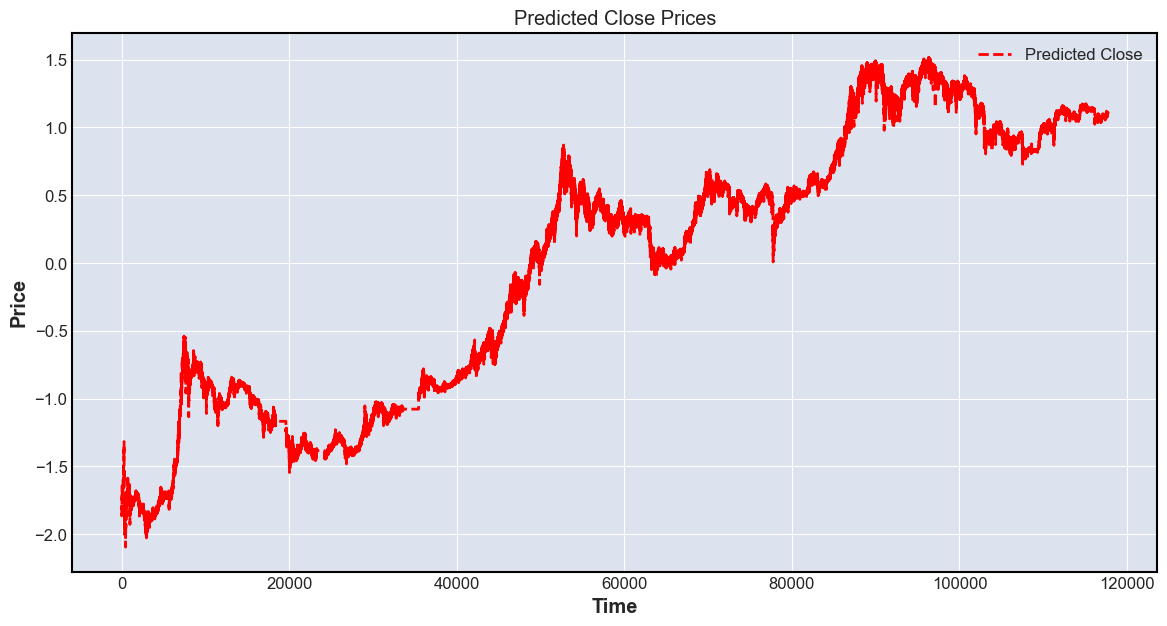

In [8]:
hidden_dim = 1718
layer_dim = 7
conv1 = 9
conv2 = 7
criterion_id = 3
seq_length = 47
batch_size = 56
lr = 1.7202934434750757e-05
model = LSTMModel(
    input_dim=5,
    hidden_dim=hidden_dim,
    layer_dim=layer_dim,
    output_dim=5,
    conv1=conv1,
    conv2=conv2,
).to(device)
model.load_state_dict(torch.load("models/cnn_lstm_params_optimized.model", weights_only=True)["model_state_dict"])
getPredPlot(model, seq_length)